# Introduction to 1D pulse acquisition (User defiend Hamiltonian)
## Author: Vineeth Thalakottoor
## Email: vineeth.thalakottoor@ens.psl.eu or vineethfrancis.physics@gmail.com# PyOR Quantum

In [1]:
# Define the source path
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/PyOR_Combined/PyOR/Source_Doc'

# Add source path
import sys
sys.path.append(SourcePath)
import time
import numpy as np
%matplotlib ipympl

# Import PyOR package
from PyOR_QuantumSystem import QuantumSystem as QunS
from PyOR_HardPulse import HardPulse
from PyOR_Evolution import Evolutions
from PyOR_Plotting import Plotting
import PyOR_SignalProcessing as Spro

In [2]:
# Define the spin system
Spin_list = {"A" : "H1", "B" : "H1"}
QS = QunS(Spin_list,PrintDefault=False)

# initialize the system
QS.Initialize()

### Set parameters

In [3]:
# Master Equation
QS.PropagationSpace = "Hilbert"
QS.MasterEquation = "Redfield"

# Operator Basis
QS.Basis_SpinOperators_Hilbert = "Zeeman" # TTry "Singlet Triplet" and see what happen to the all spin operators and Hamiltoninas

# Relaxation Process
QS.Rprocess = "Phenomenological"
QS.R1 = 1
QS.R2 = 1

QS.Update()

Larmor Frequency in MHz:  [-400.22801765 -400.22801765]


### Spin operators

In [4]:
QS.Az

In [5]:
QS.Az.matrix

Matrix([
[0.5,   0,    0,    0],
[  0, 0.5,    0,    0],
[  0,   0, -0.5,    0],
[  0,   0,    0, -0.5]])

In [6]:
QS.Az.data

array([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j, -0.5+0.j, -0. +0.j],
       [ 0. +0.j,  0. +0.j, -0. +0.j, -0.5+0.j]])

In [7]:
QS.Az_sub

In [8]:
QS.Az_sub.matrix

Matrix([
[0.5,    0],
[  0, -0.5]])

### Generate Hamiltonians

In [9]:
# 1. Zeeman Hamiltonian

Hz = 2.0 * np.pi * 10 * QS.Az + 2.0 * np.pi * 50 * QS.Bz
Hz.Inverse2PI().matrix

Matrix([
[30.0,     0,    0,     0],
[   0, -20.0,    0,     0],
[   0,     0, 20.0,     0],
[   0,     0,    0, -30.0]])

In [10]:
# 2. J coupling Hamiltonian

Hj = 2.0 * np.pi * 5 * (QS.Ax * QS.Bx + QS.Ay * QS.By + QS.Az * QS.Bz)
Hj.Inverse2PI().matrix

Matrix([
[1.25,     0,     0,    0],
[   0, -1.25,   2.5,    0],
[   0,   2.5, -1.25,    0],
[   0,     0,     0, 1.25]])

## Initialize density matrix

In [11]:
# Initial Density Matrix
rho_in = QS.Az + QS.Bz
rho_in.matrix

Matrix([
[1.0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0, -1.0]])

In [12]:
# Final Density Matrix
rhoeq = QS.Az + QS.Bz
rhoeq.matrix

Matrix([
[1.0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0, -1.0]])

## Hard Pulse

In [13]:
HardP = HardPulse(QS)

flip_angle = 90.0   # Flip angle
rho = HardP.Rotate_Pulse(rho_in,flip_angle,QS.Ay + QS.By).Tolarence(1.0e-5)
rho.matrix

Matrix([
[  0, 0.5, 0.5,   0],
[0.5,   0,   0, 0.5],
[0.5,   0,   0, 0.5],
[  0, 0.5, 0.5,   0]])

## Evolution

In [14]:
QS.AcqDT = 0.0001
QS.AcqAQ = 5.0
QS.OdeMethod = 'DOP853'
QS.PropagationMethod = "ODE Solver"

EVol = Evolutions(QS)

start_time = time.time()
t, rho_t = EVol.Evolution(rho,rhoeq,Hz+Hj)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Larmor Frequency in MHz:  [-400.22801765 -400.22801765]
Total time = 3.157172679901123 seconds 


## Expectation

In [15]:
det_Mt = QS.Ap + QS.Bp
det_Z = QS.Az + QS.Bz

t, Mt = EVol.Expectation(rho_t,det_Mt)
t, Mz = EVol.Expectation(rho_t,det_Z)

## Plotting

In [16]:
plot = Plotting(QS)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f5b5b6ad9d0>)

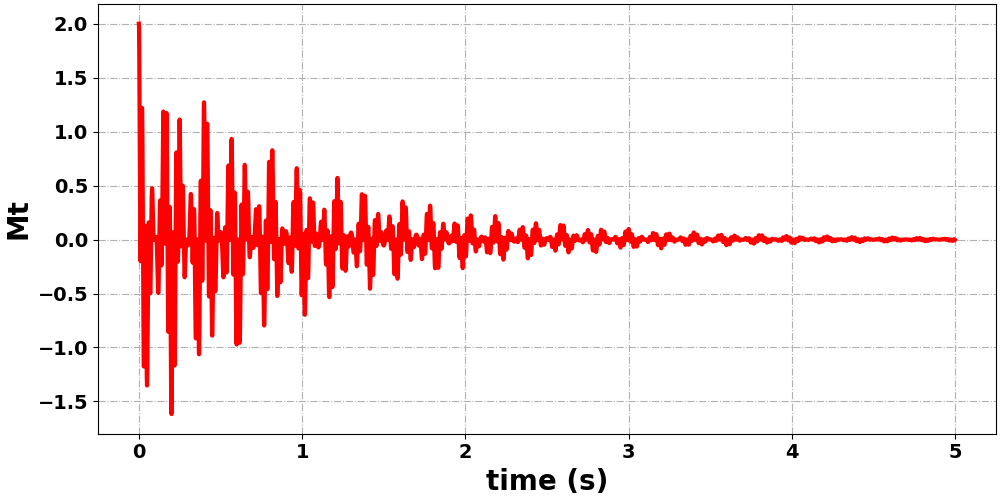

In [17]:
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.Plotting_SpanSelector(t,Mt,"time (s)","Mt","red") 

(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f5b596108f0>)

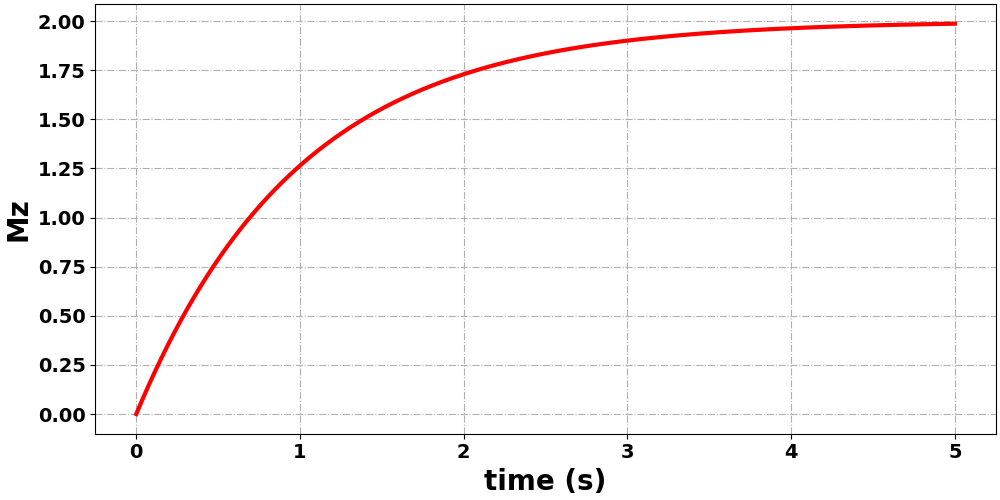

In [18]:
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.Plotting_SpanSelector(t,Mz,"time (s)","Mz","red") 

## Fourier Transform

In [19]:
freq, spectrum = Spro.FourierTransform(Mt,QS.AcqFS,5)

(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f5b58495040>)

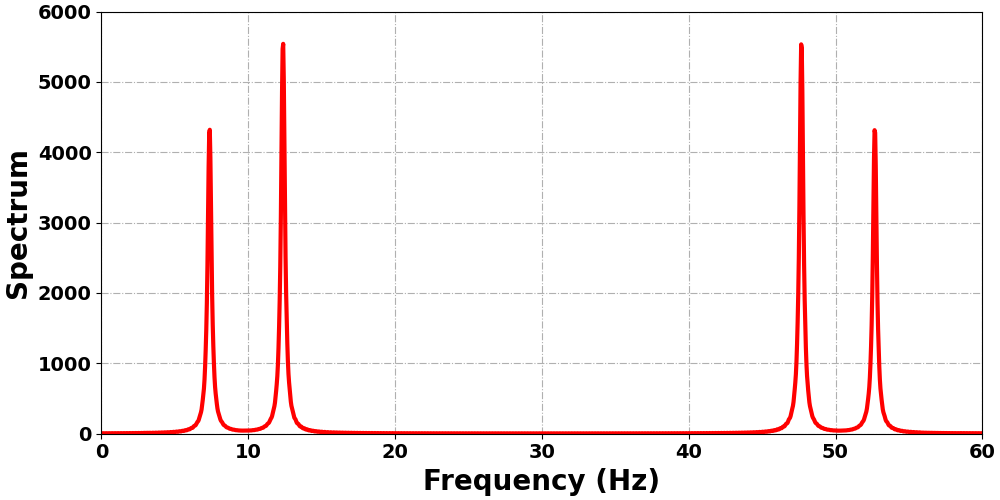

In [20]:
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.PlotXlimt= (0,60)
plot.PlotYlimt= (0,6000)
plot.Plotting_SpanSelector(freq,spectrum,"Frequency (Hz)","Spectrum","red")